In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import random
from IPython.display import clear_output
from IPython.display import Image

# Stochastic Dynamics of Reactions - Gillespie Algorithm

In this Jupyter Notebook, I have implemented a function that, given the reactions involved in a stochastic process, dynamic constants, and initial conditions, allows you to simulate the dynamics and monitor the development of quantities for each class.

The stochastic process is simulated using the Gillespie Algorithm: by using the abundances for each class and the kinetic constants for each reaction, it is possible to determine, after a time tau sampled from a Poisson distribution, the *propensies*: the probability distribution that governs the occurrence of the next reaction.

**Usage Instructions**

The function requires several input variables. First and foremost, the matrices of reactants and products are needed. These have a specific definition, and in order to obtain a meaningful simulation, it is necessary to implement them according to the following rules:

***Reagents matrix***: it has a number of rows equal to the number of reactions and columns for each class. Each element corresponds to the stoichiometric coefficient present in the reactants. In cases outside of chemistry, it may be unclear which coefficient to use, therefore the following reasoning is suggested: enter the number of individuals (of the class) that are needed to trigger that phenomenon (prey-predator -> 1 prey, 1 predator).

***Product matrix***: the number of elements created in each reaction. It can also contain negative values. For example, if a reaction requires X + Y as reactants, and the result is the disappearance of one X and the creation of one Y, we can write the reaction products as -> -1 (-X), +1 (+Y).

***Classes***: the name of each classes.

***kinetics***: the kinetic constants of each reaction.

***ic***: initial condition (list).

***T***: endtime of the simulation.

$\rightarrow$ return (***quantities_per_simulation, timepoints_per_simulation***): 

***quantities_per_simulation***, [list] historical (for each simulation) of the abundances of each class. 

***timepoints_per_simulation***, [list] time point (for each simulation) of each reaction happened, usefull to make customized plots after the simulations.

---------------------------------------
*Secondary input variables*:

*num_simulations*: you are allowed to simulate many processes (use *alpha* to regulate the transparency of the lines).

*visualize*: (Boolean) choose to visualize or not the final plot; related parameters [ *figsize*, *title* ]

*visualize_time*: (Boolean) it allows you to check the state of the simulations

*return_final_rates*: insered only for debugging; it returns (with the quantities historicals) the normalized rates historical.

*num_simulations*: number of simulations.

*alert*: in addition to break the simulation when total_rates = 0 it prints an alert message.

-------------------------------------

In [2]:
def gillepsie(Classes, reagents_matrix, products_matrix, kinetics, ic, T,
              num_simulations=1, alert=True,
              visualize=True, title='', figsize=(10,5), visualize_time=False, alpha=1,
              return_final_rates=False):
    
    quantities_per_simulation = []
    timepoints_per_simulation = []
    final_rates = []
    
    num_R = len(Classes)
    #------------------------------------------------------------------
    if visualize:
        plt.figure(figsize=figsize)
        colors = ['blue', 'green', 'red', 'cyan', 'magenta', 'pink', 'black', 'white', 'orange', 'purple']
    
    for s in range(num_simulations):#--------------------------------------
        quantities = [ic]
        choices = [x for x in range(len(kinetics))]
        #------------------------------------------------------------------
        t = 0
        ts, taus = [t], []
        rates_history = []
        ttr = []
        #------------------------------------------------------------start simulation
        while t < T:
            if visualize_time:
                if np.random.random() > 0.95:
                    clear_output(wait=True)
                    print(f'sim {s + 1}/{num_simulations} - t = {t}')
            # compute rates:
            rates, total_rate = [], 0
            for i,reagent in enumerate(reagents_matrix):
                qs = np.array(quantities[-1])
                rate = np.round( kinetics[i] * np.prod(pow(qs, reagents_matrix[i])), 3 )
                rates.append(rate)
                total_rate += rate
                
            # !!
            if total_rate == 0:
                if alert:
                    print('Dynamic ended before of endtime, total rate = 0.')
                break
            #!!
            
            rates = np.array(rates) / total_rate

            # Generate reaction time and event
            dt = np.random.exponential(1/total_rate)
            reaction_idx = np.random.choice(choices, p=rates)
            ts.append(t), taus.append(dt)
            t += dt

            # Update quantities in function of the event choosen
            qs = np.array(quantities[-1])
            new_qs = qs + products_matrix[reaction_idx]
            quantities.append(list(new_qs))

        quantities = np.array(quantities)
        quantities_per_simulation.append(quantities)
        timepoints_per_simulation.append(ts)
        final_rates.append(rates)

        if visualize:
            for i, R in enumerate(Classes):
                x = ts
                y = quantities[:, i]
                plt.plot(x, y, c=colors[i], alpha=alpha, label=f'{R}')
        #------------------------------------------------------------end simulation
    plt.title(f'{title}')
    plt.xticks(rotation=30)
    plt.xlabel(f'Time')
    leg = plt.legend(Classes)
    for line in leg.get_lines():
        line.set_alpha(1)
    plt.show()
    
    if return_final_rates:
        return quantities_per_simulation, timepoints_per_simulation, final_rates
    else:
        return quantities_per_simulation, timepoints_per_simulation

-------------------------------------------

## Simple Dynamics

3 reagents - 2 reactions

a) $A + 2B \xrightarrow{ka} C$

b) $C \xrightarrow{kb} 3A$

sim 1/1 - t = 0.0003840945784058624


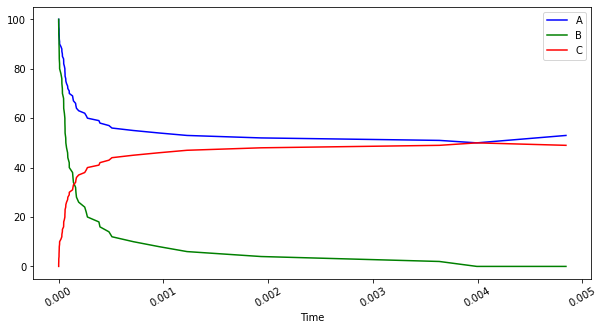

In [3]:
Elements = ['A', 'B', 'C']

reagents = np.array([[1, 2, 0],
                     [0, 0, 1]])
products = np.array([[-1, -2, 1],
                     [3, 0, -1]])


kinetics = np.array([0.8, 0.5])

ic = [100, 100, 0]

T = 0.01
quantities_per_simulation, timepoints_per_simulation = gillepsie(Elements, reagents, products, kinetics, ic, T,
                                                                 visualize_time=True,
                                                                 visualize=True, title='')

-------------------------------------------------------------------------

## Complex Dynamics

6 reagents - 6 reactions

a) $A + 2B \xrightarrow{ka} C$

b) $B + 2C \xrightarrow{kb} 2D + A$

c) $2A + D \xrightarrow{kc} E + B$

d) $E \xrightarrow{kd} A + F$



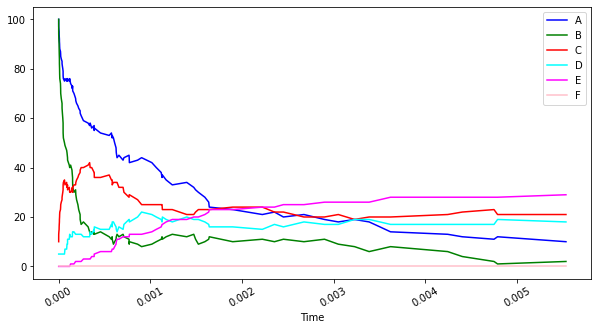

In [4]:
Elements = ['A', 'B', 'C', 'D', 'E', 'F']

reagents = np.array([[1, 2, 0, 0, 0, 0], # a)
                     [0, 1, 2, 0, 0, 0], # b)
                     [2, 0, 0, 1, 0, 0], # c)
                     [0, 0, 0, 0, 1, 0]  # d)
                     ])
products = np.array([[-1, -2, 1, 0, 0, 0], # a)
                     [1, -1, -2, 2, 0, 0], # b)
                     [-2, 1, 0, -1, 1, 0], # c)
                     [1, 0, 0, 0, -1, 1]  # d)
                     ])

kinetics = np.array([0.8, 0.5, 0.3, 0.1])

ic = [100, 100, 10, 5, 0, 0]

T = 0.008
quantities_per_simulation, timepoints_per_simulation = gillepsie(Elements, reagents, products, kinetics, ic, T,
                                                                 visualize=True, title=r'')

--------------------------------------
## Rock - Paper - Scissor simulation

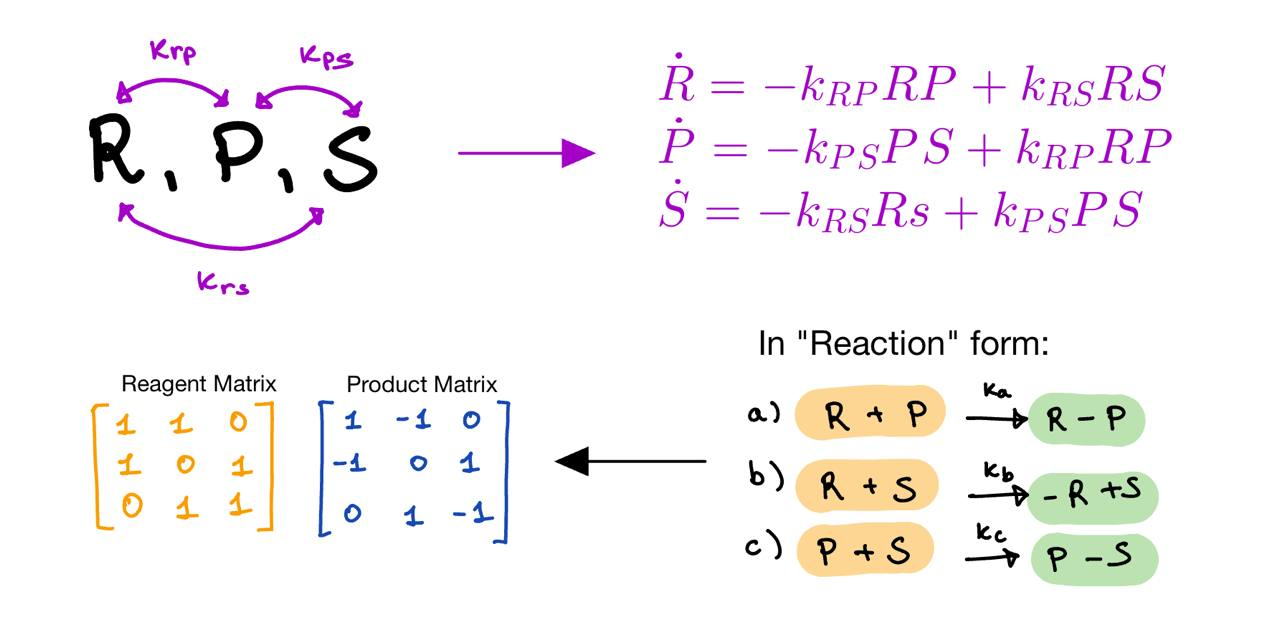

In [5]:
Image(filename="RPS.jpg")

sim 1/1 - t = 0.1995277015902619


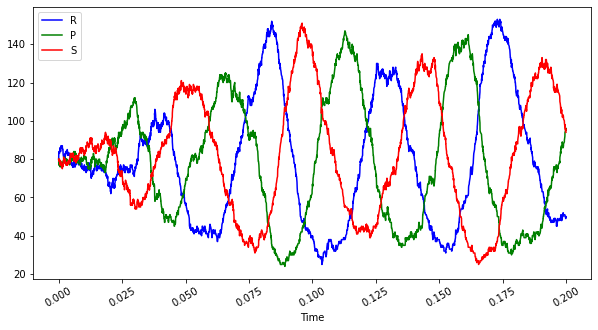

In [6]:
Elements = ['R', 'P', 'S']

reagents_coeff = np.array([[1, 1, 0],   # R,P
                           [1, 0, 1],   # R,S
                           [0, 1, 1]    # P,S
                           ])

products_coeff = np.array([[1, -1, 0],   # R - P 
                           [-1, 0, 1],  # -R + S
                           [0, 1, -1]    # P - S
                           ])  

m = 80
ic = np.array([1*m, 1*m, 1*m])

Krp, Krs, Kps = 1, 1, 1
kinetics = np.array([Krp, Krs, Kps])

T = 0.2

Q, Ts = gillepsie(Elements, reagents_coeff, products_coeff, kinetics, ic, T,
                  num_simulations=1, alpha=1,
                  visualize_time=True)

sim 10/10 - t = 0.19922418336118003


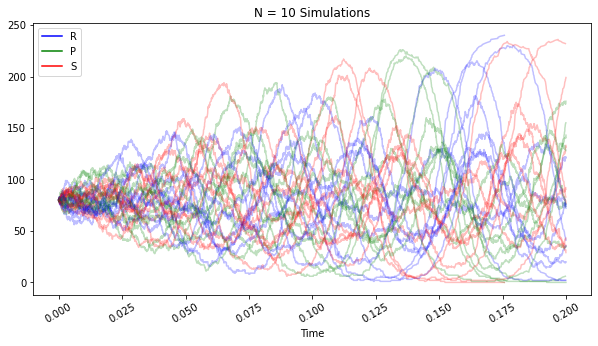

In [7]:
N = 10
T = 0.2
Q, Ts = gillepsie(Elements, reagents_coeff, products_coeff, kinetics, ic, T,
                  num_simulations=N, alpha=0.25, title=f'N = {N} Simulations',
                  alert=False,
                  visualize_time=True)

-------------------------------------------------
## Prey - Predator

ODEs:

$\begin{aligned} & \frac{d x}{d t}=\alpha x-\beta x y \\ & \frac{d y}{d t}=\beta x y-\gamma y\end{aligned}$

Reactions:

a) $ \phi \stackrel{\alpha}{\longrightarrow} X $

b) $ X + Y \stackrel{\beta}{\longrightarrow} - X + Y $ : rate of $X$, $Y$ interaction, with $X$ death and $Y$ birth

c) $ Y \stackrel{\gamma}{\longrightarrow} - Y $ : it's different fom $a)$, in this case the predator death rate depends from $Y$ quantity

***1 simulation***

sim 1/1 - t = 29.301326875907144


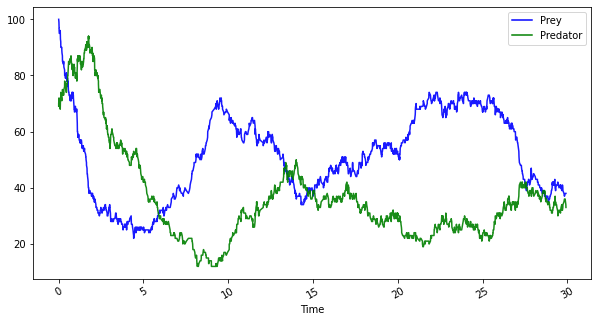

last quantities: preys = [100  70], predators = [100  69]


In [8]:
Elements = ['Prey', 'Predator']

reagents = np.array([[0, 0],   # a)
                     [1, 1], # b)
                     [0, 1]    # c)
                     ])
products = np.array([[1, 0], # a)
                     [-1, 1], # b)
                     [0, -1]  # c)
                     ])

factor = 2
alpha = 8 * factor
beta = 0.005 * factor
gamma = 0.25 * factor
kinetics = np.array([alpha, beta, gamma])

ic = [100, 70]

T = 30
quantities, ts = gillepsie(Elements, reagents, products, kinetics, ic, T,
                            num_simulations=1, alpha=0.9,
                            visualize=True, title=r'', visualize_time=True,
                            return_final_rates=False)

print(f'last quantities: preys = {quantities[-1][0]}, predators = {quantities[-1][1]}')

***N simulations***

sim 20/20 - t = 29.49442246788347


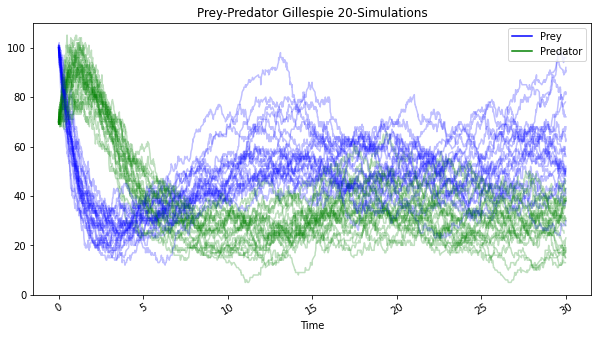

In [9]:
N = 20
all_quantities, all_ts = gillepsie(Elements, reagents, products, kinetics, ic, T,
                       num_simulations=N, alpha=0.25,
                       visualize=True, title=f'Prey-Predator Gillespie {N}-Simulations', visualize_time=True,
                       return_final_rates=False)

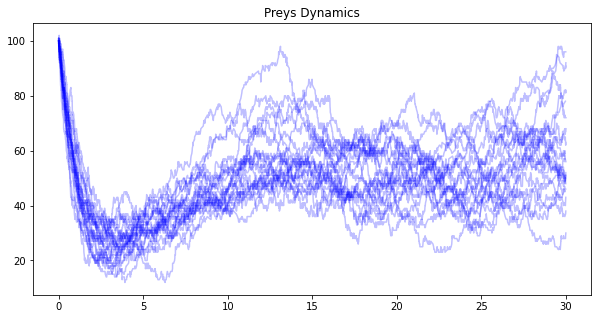

In [10]:
class_idx = 0 # prey
plt.figure(figsize=(10,5))
for i in range(N):
    plt.plot(all_ts[i], all_quantities[i][:,class_idx], c='blue', alpha=0.25)

plt.title('Preys Dynamics');

--------------------------------------------------------------------------------------
## Methane Production

a) $ C_6H_{12}O_6 \xrightarrow{ka} 6 H_2 + 6 CO $

b) $ CO + 3 H_2 \xrightarrow{kb} 5CH_4 + H_2O $

c) $ CO + H_2O \xrightarrow{kc} CO_2 + H_2 $

sim 1/1 - t = 88656.90528607748


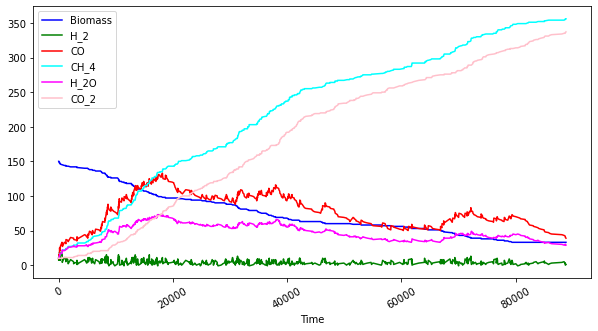

In [11]:
Elements = ['Biomass', 'H_2', 'CO', 'CH_4', 'H_2O', 'CO_2']

reagents_coeff = np.array([[1, 0, 0, 0, 0, 0],   # a)
                           [0, 3, 1, 0, 0, 0],   # b)
                           [0, 0, 1, 0, 1, 0]    # c)
                           ])

products_coeff = np.array([[-1, 6, 6, 0, 0, 0],   # a)
                           [0, -3, -1, 1, 1, 0],   # b)
                           [0, 1, -1, 0, -1, 1]    # c)
                           ])  

m = 10
ic = np.array([15, 1, 1, 1, 1, 1]) * m

f = 0.000001
ka, kb, kc = 15*f, 1*f, 1*f
kinetics = np.array([ka, kb, kc])

T = 90000

Q, Ts, rs = gillepsie(Elements, reagents_coeff, products_coeff, kinetics, ic, T,
                  num_simulations=1, alpha=1,
                  return_final_rates=True,
                  visualize_time=True)

**N - Simulations**

sim 10/10 - t = 89142.23877717824


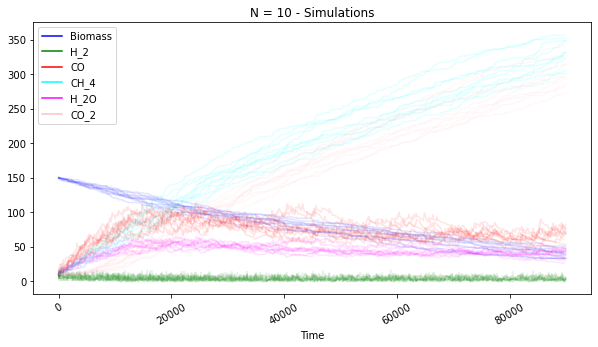

In [12]:
N = 10
QN, TsN, rsN = gillepsie(Elements, reagents_coeff, products_coeff, kinetics, ic, T,
                  num_simulations=N, alpha=0.1, title=f'N = {N} - Simulations',
                  return_final_rates=True,
                  visualize_time=True)

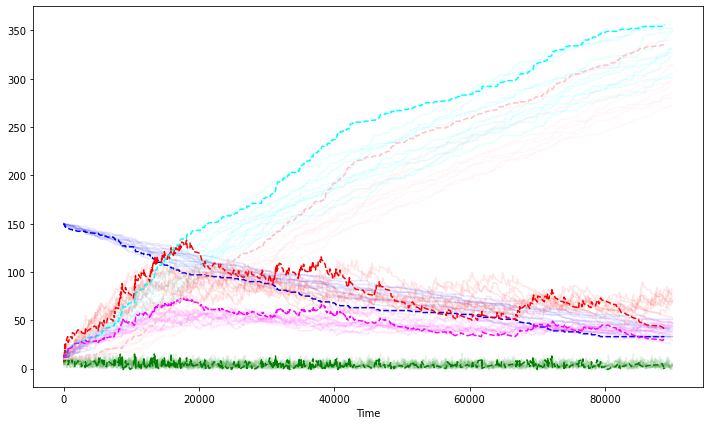

In [13]:
colors = ['blue', 'green', 'red', 'cyan', 'magenta', 'pink', 'black', 'white', 'orange', 'purple']
plt.figure(figsize=(12,7))
for i in range(len(Elements)):
    plt.plot(Ts[0], Q[0][:,i], c=colors[i], linestyle='dashed')
    for n in range(N):
        plt.plot(TsN[n], QN[n][:,i], c=colors[i], alpha=0.1)
plt.xlabel('Time')
plt.show()